# **What factors most influence the likelihood of an H-1B visa application being denied, based on employer characteristics, job title, wage levels, and job location?**




**Initial Pre-Processing**

Load raw data, drop columns, fill missing values, save cleaned chunks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
# os.listdir('/content/drive/MyDrive/')
# File paths
input_file_path = '/content/drive/MyDrive/ISDS 577 Capstone Project/Combined_LCA_Disclosure_Data_FY2020_to_FY2024.csv'
output_file_path = '/content/drive/MyDrive/Cleaned_LCA_Disclosure_Data_Chunked.csv'

# Remove output file if it exists
if os.path.exists(output_file_path):
    os.remove(output_file_path)

# Parameters
chunk_size = 100_000
first_chunk = True
fill_values = {}

# Iterate through chunks
for chunk in pd.read_csv(input_file_path, chunksize=chunk_size, low_memory=False):
    chunk.columns = chunk.columns.str.strip().str.lower().str.replace(" ", "_")

    if first_chunk:
        # Drop columns with >50% missing values (only checking in first chunk)
        missing_percent = chunk.isnull().mean() * 100
        cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
        chunk.drop(columns=cols_to_drop, inplace=True, errors='ignore')

        # Fill strategies
        numeric_cols = chunk.select_dtypes(include=[np.number]).columns
        object_cols = chunk.select_dtypes(include=["object"]).columns

        for col in numeric_cols:
            fill_values[col] = chunk[col].median()
        for col in object_cols:
            if not chunk[col].mode().empty:
                fill_values[col] = chunk[col].mode().iloc[0]
            else:
                fill_values[col] = "No Data"

        first_chunk = False

    else:
        chunk.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    # Fill missing values using global fill_values
    chunk.fillna(fill_values, inplace=True)

    # Save cleaned chunk to file
    chunk.to_csv(output_file_path, mode='a', index=False, header=not os.path.exists(output_file_path))

print("✅ All chunks processed and saved to:", output_file_path)

# Shape of the data: (3564698, 72)

Mounted at /content/drive
✅ All chunks processed and saved to: /content/drive/MyDrive/Cleaned_LCA_Disclosure_Data_Chunked.csv


**Final Pre-Processing and Feature Normalization**

Wage normalization, date parsing, binary encoding, save final dataset

In [ ]:
import pandas as pd
import numpy as np

# Load cleaned data in chunks
file_path = '/content/drive/MyDrive/Cleaned_LCA_Disclosure_Data_Chunked.csv'
chunk_size = 100000
chunks = pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)

# Initialize a list to hold processed chunks
cleaned_chunks = []

# Required columns for your research
required_columns = [
    'case_status', 'employer_name', 'h_1b_dependent', 'willful_violator',
    'job_title', 'soc_code', 'soc_title',
    'wage_rate_of_pay_from', 'prevailing_wage', 'wage_unit_of_pay',
    'worksite_city', 'worksite_state', 'worksite_postal_code',
    'received_date', 'decision_date', 'year'
]

# Helper function to normalize wage to hourly
def convert_to_hourly(wage, unit):
    if pd.isna(wage):
        return np.nan
    unit = str(unit).strip().upper()
    if unit == 'YEAR':
        return wage / 2080
    elif unit == 'MONTH':
        return wage * 12 / 2080
    elif unit == 'WEEK':
        return wage * 52 / 2080
    elif unit == 'BI-WEEKLY':
        return wage * 26 / 2080
    elif unit == 'HOUR':
        return wage
    else:
        return np.nan

# Process each chunk
for i, chunk in enumerate(chunks):
    # Drop duplicates
    chunk.drop_duplicates(inplace=True)

    # Select required columns
    chunk = chunk[[col for col in required_columns if col in chunk.columns]].copy()

    # Handle missing values
    for col in chunk.columns:
        if chunk[col].dtype in [np.float64, np.int64]:
            chunk[col] = chunk[col].fillna(chunk[col].median())
        elif chunk[col].dtype == "object":
            mode = chunk[col].mode()
            chunk[col] = chunk[col].fillna(mode[0] if not mode.empty else "No Data")

    # Convert dates
    chunk['received_date'] = pd.to_datetime(chunk['received_date'], errors='coerce')
    chunk['decision_date'] = pd.to_datetime(chunk['decision_date'], errors='coerce')

    # Drop rows with invalid dates
    chunk.dropna(subset=['received_date', 'decision_date'], inplace=True)

    # Normalize wage columns to hourly
    chunk['wage_rate_hourly'] = chunk.apply(
        lambda row: convert_to_hourly(row['wage_rate_of_pay_from'], row['wage_unit_of_pay']), axis=1)
    chunk['prevailing_wage_hourly'] = chunk.apply(
        lambda row: convert_to_hourly(row['prevailing_wage'], row['wage_unit_of_pay']), axis=1)

    # Drop original wage columns
    chunk.drop(columns=['wage_rate_of_pay_from', 'prevailing_wage', 'wage_unit_of_pay'], inplace=True)

    # Encode categorical columns
    categorical_cols = ['case_status', 'employer_name', 'h_1b_dependent', 'willful_violator',
                        'job_title', 'soc_code', 'soc_title', 'worksite_city', 'worksite_state', 'worksite_postal_code']
    for col in categorical_cols:
        if col in chunk.columns:
            chunk[col] = chunk[col].fillna("No Data").astype(str)

    # Binary encode Y/N fields
    chunk['h_1b_dependent'] = chunk['h_1b_dependent'].replace({'Y': 1, 'N': 0, 'No Data': 0})
    chunk['willful_violator'] = chunk['willful_violator'].replace({'Y': 1, 'N': 0, 'No Data': 0})

    # Calculate Decision Duration in days (new feature)
    chunk['decision_duration'] = (chunk['decision_date'] - chunk['received_date']).dt.days

    # Append cleaned chunk
    cleaned_chunks.append(chunk)

# Combine all cleaned chunks
df = pd.concat(cleaned_chunks, ignore_index=True)
print("\nCombined full dataset shape after preprocessing:", df.shape)

# Detect outliers (informational only)
for wage_col in ['wage_rate_hourly', 'prevailing_wage_hourly']:
    Q1 = df[wage_col].quantile(0.25)
    Q3 = df[wage_col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[wage_col] < lower) | (df[wage_col] > upper)].shape[0]
    print(f"Outliers in {wage_col}: {outliers}")

# Save final preprocessed dataset
final_path = '/content/drive/MyDrive/Final_Cleaned_H1B_Data.csv'
df.to_csv(final_path, index=False)
print("Final cleaned dataset saved to:", final_path)
print("Final columns:", df.columns.tolist())
print(df[['received_date', 'decision_date', 'decision_duration']].head(10))


Final cleaned dataset saved to: /content/drive/MyDrive/Final_Cleaned_H1B_Data.csv
Final columns: ['case_status', 'employer_name', 'h_1b_dependent', 'willful_violator', 'job_title', 'soc_code', 'soc_title', 'worksite_city', 'worksite_state', 'worksite_postal_code', 'received_date', 'decision_date', 'wage_rate_hourly', 'prevailing_wage_hourly', 'decision_duration']
  received_date decision_date  decision_duration
0    2019-09-25    2019-10-01                  6
1    2019-09-25    2019-10-01                  6
2    2019-09-25    2019-10-01                  6
3    2019-09-25    2019-10-01                  6
4    2019-09-25    2019-10-01                  6
5    2019-09-25    2019-10-01                  6
6    2019-09-25    2019-10-01                  6
7    2019-09-25    2019-10-01                  6
8    2019-09-25    2019-10-01                  6
9    2019-09-25    2019-10-01                  6


**Feature Engineering**

Create decision duration, log-transform wages, minimal one-hot encoding

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc

# File paths
input_path = '/content/drive/MyDrive/Final_Cleaned_H1B_Data.csv'
output_path = '/content/drive/MyDrive/Feature_Engineered_H1B_Data.csv'

# Chunk parameters
chunk_size = 50000
first_chunk = True
total_rows = 0

# Chunk iterator
chunk_iter = pd.read_csv(input_path, chunksize=chunk_size)

# Process each chunk
for i, chunk in enumerate(chunk_iter):
   # print(f"\n Processing chunk {i + 1} of size {len(chunk)}...")
    total_rows += len(chunk)

    # Handle missing values
    chunk['h_1b_dependent'] = chunk['h_1b_dependent'].replace('No Data', np.nan)
    chunk['willful_violator'] = chunk['willful_violator'].replace('No Data', np.nan)

    chunk['h_1b_dependent'] = chunk['h_1b_dependent'].fillna(chunk['h_1b_dependent'].mode()[0] if not chunk['h_1b_dependent'].mode().empty else 'N')
    chunk['willful_violator'] = chunk['willful_violator'].fillna(chunk['willful_violator'].mode()[0] if not chunk['willful_violator'].mode().empty else 'N')

    for col in chunk.select_dtypes(include=[np.number]).columns:
        chunk[col] = chunk[col].fillna(chunk[col].median())

    for col in chunk.select_dtypes(include=['object']).columns:
        if col not in ['h_1b_dependent', 'willful_violator']:
            mode = chunk[col].mode()
            chunk[col] = chunk[col].fillna(mode[0] if not mode.empty else "No Data")

    # Time-based Features
    chunk['received_date'] = pd.to_datetime(chunk['received_date'], errors='coerce')
    chunk['decision_date'] = pd.to_datetime(chunk['decision_date'], errors='coerce')
    chunk['received_year'] = chunk['received_date'].dt.year
    chunk['received_month'] = chunk['received_date'].dt.month
    chunk['received_day_of_week'] = chunk['received_date'].dt.dayofweek
    chunk['decision_duration'] = (chunk['decision_date'] - chunk['received_date']).dt.days

    # One-Hot Encoding (low cardinality only)
    for col in ['job_title', 'soc_title', 'worksite_city', 'worksite_state']:
        unique_vals = chunk[col].nunique()
        if unique_vals <= 30:
            dummies = pd.get_dummies(chunk[col], prefix=col, drop_first=True)
            chunk = pd.concat([chunk.drop(columns=[col]), dummies], axis=1)
          #  print(f" One-hot encoding applied to: {col} ({unique_vals} categories).")
        else:
            print(f"Skipped one-hot encoding for {col} (too many categories: {unique_vals}).")

    # Label Encode Binary Columns
    chunk['h_1b_dependent'] = chunk['h_1b_dependent'].replace({'Y': 1, 'N': 0})
    chunk['willful_violator'] = chunk['willful_violator'].replace({'Y': 1, 'N': 0})
   # print("Label encoding applied to 'h_1b_dependent' and 'willful_violator'.")

    # Log Transform Wage Columns
    for col in ['wage_rate_hourly', 'prevailing_wage_hourly']:
        chunk[col] = chunk[col].apply(lambda x: np.log(x + 1) if pd.notnull(x) and x > 0 else 0)

    # Final check for any remaining missing values
    missing_counts = chunk.isnull().sum()
    if missing_counts.sum() > 0:
        print("Missing values after cleaning in this chunk:")
        print(missing_counts[missing_counts > 0])
    else:
        print("No missing values in this chunk after processing.")

    # Drop unused columns
    drop_cols = ['received_date', 'decision_date', 'worksite_postal_code']
    chunk.drop(columns=[col for col in drop_cols if col in chunk.columns], inplace=True)

    # Save processed chunk
    if first_chunk:
        chunk.to_csv(output_path, index=False)
        first_chunk = False
    else:
        chunk.to_csv(output_path, mode='a', index=False, header=False)

    # Free up memory to avoid RAM issues
    del chunk
    gc.collect()

# Final Summary
print(f"Total rows processed: {total_rows}")
# Load a sample from the final file to inspect structure
sample = pd.read_csv(output_path, nrows=5)
print(f"Final dataset shape (approx): {total_rows} rows x {sample.shape[1]} columns")
print(f"Final feature columns:\n{list(sample.columns)}")


Total rows processed: 3543559
Final dataset shape (approx): 3543559 rows x 15 columns
Final feature columns:
['case_status', 'employer_name', 'h_1b_dependent', 'willful_violator', 'job_title', 'soc_code', 'soc_title', 'worksite_city', 'worksite_state', 'wage_rate_hourly', 'prevailing_wage_hourly', 'decision_duration', 'received_year', 'received_month', 'received_day_of_week']


**Feature Selection (Correlation-Based)**

Drop highly correlated redundant features

In [ ]:
import pandas as pd
import numpy as np
import gc

def feature_selection(input_path, output_path, correlation_threshold=0.85):
    # Read the feature-engineered dataset in chunks
    chunk_size = 50000
    chunk_iter = pd.read_csv(input_path, chunksize=chunk_size)

    first_chunk = True
    columns_to_drop = set() # To keep track of columns to drop after correlation-based selection
    total_rows = 0
    final_columns = None


    for i, chunk in enumerate(chunk_iter):
      #  print(f"\n Processing chunk {i + 1}...")

        # Calculate the correlation matrix only for numerical columns
        df_numeric = chunk.select_dtypes(include=[np.number])
        corr_matrix = df_numeric.corr()

        # Find features that are highly correlated (greater than the threshold)
        to_drop = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                    colname = corr_matrix.columns[i]
                    to_drop.add(colname)

        # Exclude 'prevailing_wage_hourly' and 'decision_duration' from being dropped
        to_drop.discard('prevailing_wage_hourly')
        to_drop.discard('decision_duration')

        columns_to_drop.update(to_drop)

        # Drop the correlated columns from the current chunk
        chunk = chunk.drop(columns=columns_to_drop)
        total_rows += chunk.shape[0]
        final_columns = chunk.columns.tolist()  # Overwrite every time, final value = final columns


       # print(f" Dropped {len(columns_to_drop)} columns due to high correlation.")

        # Save the processed chunk (append to file)
        if first_chunk:
            chunk.to_csv(output_path, index=False)
            first_chunk = False
        else:
            chunk.to_csv(output_path, mode='a', index=False, header=False)

        # Free memory after processing each chunk
        del chunk
        gc.collect()

        print(f"\n Feature selection complete. Dropped {len(columns_to_drop)} columns: {list(columns_to_drop)}")
        print(f"Final dataset shape: ({total_rows}, {len(final_columns)})")

# Path to the feature-engineered dataset
input_path = '/content/drive/MyDrive/Feature_Engineered_H1B_Data.csv'
output_path = '/content/drive/MyDrive/Feature_Engineered_H1B_Data_Selected_Features.csv'

# Perform feature selection
feature_selection(input_path, output_path)

# Based on correlation analysis, received_year and received_month were highly redundant with decision_duration. Since decision_duration captures the application's processing time more precisely, we retained it and dropped the redundant features to reduce noise and multicollinearity


 Feature selection complete. Dropped 1 columns: ['received_year']
Final dataset shape: (50000, 14)

 Feature selection complete. Dropped 1 columns: ['received_year']
Final dataset shape: (100000, 14)

 Feature selection complete. Dropped 2 columns: ['received_year', 'received_month']
Final dataset shape: (150000, 13)

 Feature selection complete. Dropped 2 columns: ['received_year', 'received_month']
Final dataset shape: (200000, 13)

 Feature selection complete. Dropped 2 columns: ['received_year', 'received_month']
Final dataset shape: (250000, 13)

 Feature selection complete. Dropped 2 columns: ['received_year', 'received_month']
Final dataset shape: (300000, 13)

 Feature selection complete. Dropped 2 columns: ['received_year', 'received_month']
Final dataset shape: (350000, 13)

 Feature selection complete. Dropped 2 columns: ['received_year', 'received_month']
Final dataset shape: (400000, 13)

 Feature selection complete. Dropped 2 columns: ['received_year', 'received_month']


**Random Forest Modeling: Predicting H-1B Denials**

Model training, evaluation, and feature analysis

Classification Report:
                       precision    recall  f1-score   support

            Certified       1.00      0.99      0.99    654494
Certified - Withdrawn       0.90      0.95      0.93     37098
               Denied       0.37      0.89      0.52      4331
            Withdrawn       0.92      0.84      0.87     12789

             accuracy                           0.98    708712
            macro avg       0.80      0.91      0.83    708712
         weighted avg       0.99      0.98      0.98    708712



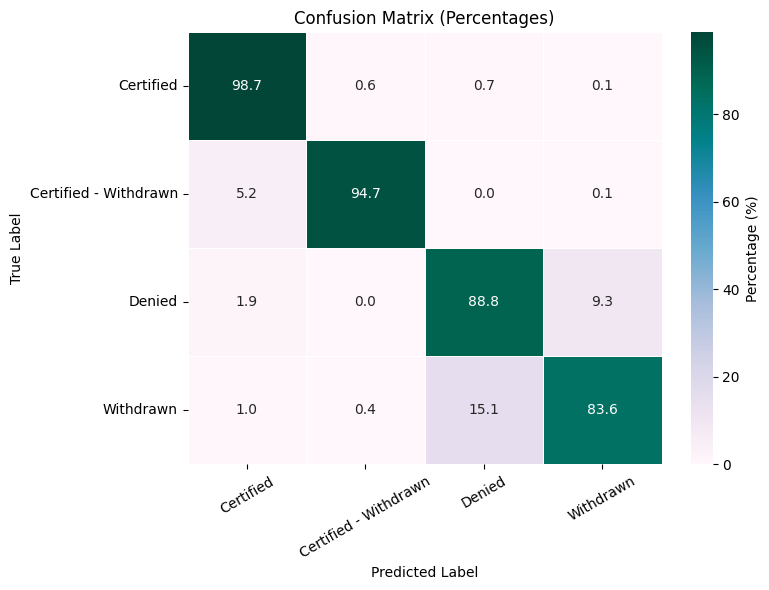

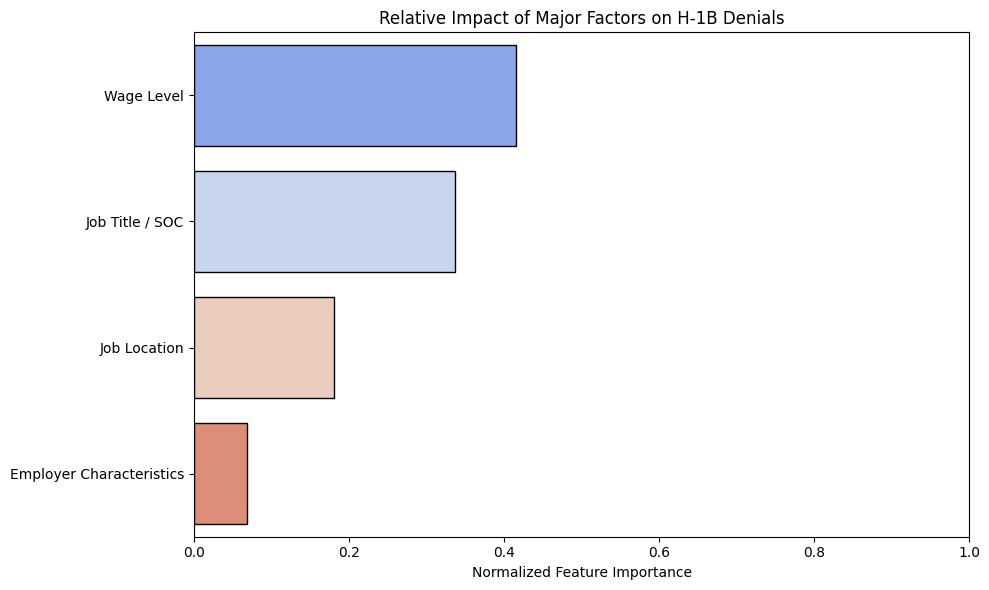

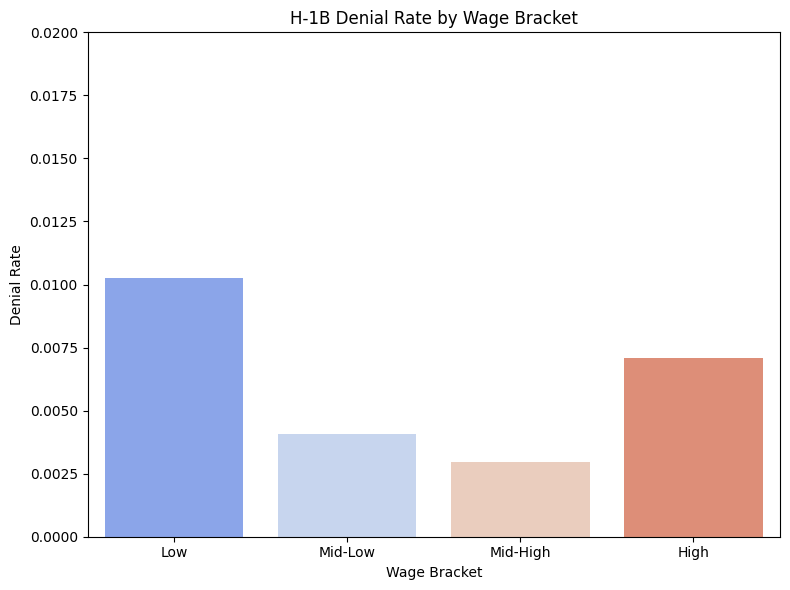

<ipython-input-8-d626ddcb6e34>:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_jobs = df_copy.groupby('soc_title').apply(


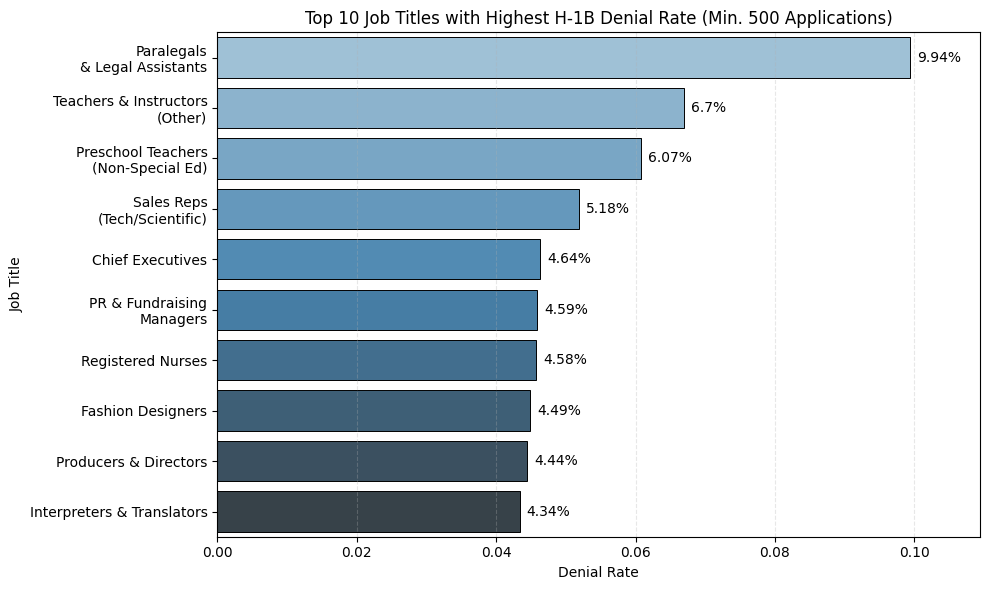

<ipython-input-8-d626ddcb6e34>:178: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  denial_trend = pd.read_csv('/content/drive/MyDrive/Feature_Engineered_H1B_Data.csv')


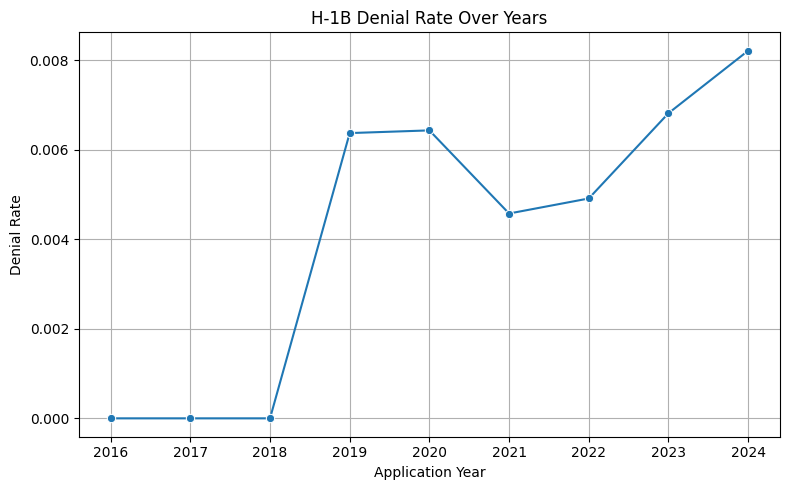

Total execution time: 74.92 seconds


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

# Start timer
start_time = time.time()

# Load dataset
input_path = '/content/drive/MyDrive/Feature_Engineered_H1B_Data_Selected_Features.csv'
data = pd.read_csv(input_path, low_memory=False)

# Drop rows with missing target
data = data.dropna(subset=['case_status'])

# Encode target variable
target_encoder = LabelEncoder()
data['case_status'] = target_encoder.fit_transform(data['case_status'])
y = data['case_status']
X = data.drop(columns=['case_status'])

# Encode categorical features
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fill missing values
X_train = X_train.fillna(X_train.median(numeric_only=True)).fillna(-1)
X_test = X_test.fillna(X_test.median(numeric_only=True)).fillna(-1)

# Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Train Random Forest model
rf = RandomForestClassifier(
    n_estimators=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

# Plot1: Confusion Matrix (Percent Format)
labels = sorted(np.unique(y_test))
label_names = target_encoder.inverse_transform(labels)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='PuBuGn', linewidths=0.5,
            xticklabels=label_names, yticklabels=label_names, cbar_kws={'label': 'Percentage (%)'})
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot2: Feature Importance by Group
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

def map_to_category(feature):
    if feature in ['wage_rate_hourly', 'prevailing_wage_hourly']:
        return 'Wage Level'
    elif feature in ['h_1b_dependent', 'willful_violator']:
        return 'Employer Characteristics'
    elif feature in ['job_title', 'soc_code', 'soc_title']:
        return 'Job Title / SOC'
    elif feature in ['worksite_city', 'worksite_state']:
        return 'Job Location'
    else:
        return 'Other'

importance_df['Category'] = importance_df['Feature'].apply(map_to_category)
category_importance = importance_df.groupby('Category')['Importance'].sum().reset_index()
category_importance = category_importance[category_importance['Category'] != 'Other']
category_importance['Normalized Impact'] = category_importance['Importance'] / category_importance['Importance'].sum()

plt.figure(figsize=(10, 6))
sns.barplot(data=category_importance.sort_values('Normalized Impact', ascending=False),
            x='Normalized Impact', y='Category', hue='Category', legend=False,
            palette='coolwarm', edgecolor='black')
plt.title('Relative Impact of Major Factors on H-1B Denials')
plt.xlabel('Normalized Feature Importance')
plt.ylabel('')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Plot3: Denial Rate by Wage Bracket
df_copy = data.copy()
df_copy['case_status_decoded'] = target_encoder.inverse_transform(data['case_status'])
df_copy['wage_bracket'] = pd.qcut(df_copy['wage_rate_hourly'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

denial_rate_by_wage = df_copy.groupby('wage_bracket', observed=True)['case_status_decoded'].value_counts(normalize=True).unstack().fillna(0)
denial_rate_by_wage['Denial Rate'] = denial_rate_by_wage.get('Denied', 0)

plt.figure(figsize=(8, 6))
sns.barplot(x=denial_rate_by_wage.index, y=denial_rate_by_wage['Denial Rate'],
            hue=denial_rate_by_wage.index, palette='coolwarm', legend=False)
plt.title('H-1B Denial Rate by Wage Bracket')
plt.ylabel('Denial Rate')
plt.xlabel('Wage Bracket')
plt.ylim(0, 0.02)
plt.tight_layout()
plt.show()

# Plot4: Top 10 Job Titles by Denial Rate
# Create Top Denial Titles DataFrame
top_jobs = df_copy.groupby('soc_title').apply(
    lambda x: (x['case_status_decoded'] == 'Denied').sum() / len(x)
).reset_index(name='Denial Rate')

# Filter to titles with at least 500 applications
application_counts = df_copy['soc_title'].value_counts()
top_jobs = top_jobs[top_jobs['soc_title'].isin(application_counts[application_counts >= 500].index)]

# Select Top 10
top_denial_titles = top_jobs.sort_values('Denial Rate', ascending=False).head(10)
top_denial_titles['Denial %'] = (top_denial_titles['Denial Rate'] * 100).round(2)

# Title cleaning
title_label_map = {
    'Paralegals and Legal Assistants': 'Paralegals\n& Legal Assistants',
    'Teachers and Instructors, All Other': 'Teachers & Instructors\n(Other)',
    'Preschool Teachers, Except Special Education': 'Preschool Teachers\n(Non-Special Ed)',
    'Sales Representatives, Wholesale and Manufacturing, Technical and Scientific Products': 'Sales Reps\n(Tech/Scientific)',
    'Chief Executives': 'Chief Executives',
    'Public Relations and Fundraising Managers': 'PR & Fundraising\nManagers',
    'Registered Nurses': 'Registered Nurses',
    'Fashion Designers': 'Fashion Designers',
    'Producers and Directors': 'Producers & Directors',
    'Interpreters and Translators': 'Interpreters & Translators'
}

# Apply cleaned labels
top_denial_titles['Label'] = top_denial_titles['soc_title'].map(title_label_map)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_denial_titles, x='Denial Rate', y='Label', hue='Label',
                 palette='Blues_d', legend=False, edgecolor='black', linewidth=0.7)

for i, (rate, pct) in enumerate(zip(top_denial_titles['Denial Rate'], top_denial_titles['Denial %'])):
    ax.text(rate + 0.001, i, f"{pct}%", va='center', ha='left', fontsize=10)

plt.title('Top 10 Job Titles with Highest H-1B Denial Rate (Min. 500 Applications)')
plt.xlabel('Denial Rate')
plt.ylabel('Job Title')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.xlim(0, top_denial_titles['Denial Rate'].max() + 0.01)
plt.tight_layout()
plt.show()

# Load feature engineered but not feature selected data
denial_trend = pd.read_csv('/content/drive/MyDrive/Feature_Engineered_H1B_Data.csv')

# Create Denied flag
denial_trend['Denied'] = (denial_trend['case_status'] == 'Denied').astype(int)

# Plot5: Plot Denial Rate Over Years
yearly_denials = denial_trend.groupby('received_year')['Denied'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=yearly_denials, x='received_year', y='Denied', marker='o')
plt.title('H-1B Denial Rate Over Years')
plt.xlabel('Application Year')
plt.ylabel('Denial Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


# Print total execution time
print("Total execution time: {:.2f} seconds".format(time.time() - start_time))


Our Random Forest model was specifically trained and balanced to focus on predicting H-1B visa denials. The analysis highlights how employer characteristics, wage levels, job types, and work locations influence the likelihood of a denial

**XGBoost Modeling: Predicting H-1B Denials**

Model training complete. Time: 39.50 seconds
Classification Report:
                       precision    recall  f1-score   support

            Certified       1.00      0.99      0.99    654494
Certified - Withdrawn       0.90      0.95      0.92     37098
               Denied       0.45      0.86      0.59      4331
            Withdrawn       0.92      0.80      0.86     12789

             accuracy                           0.98    708712
            macro avg       0.82      0.90      0.84    708712
         weighted avg       0.99      0.98      0.99    708712



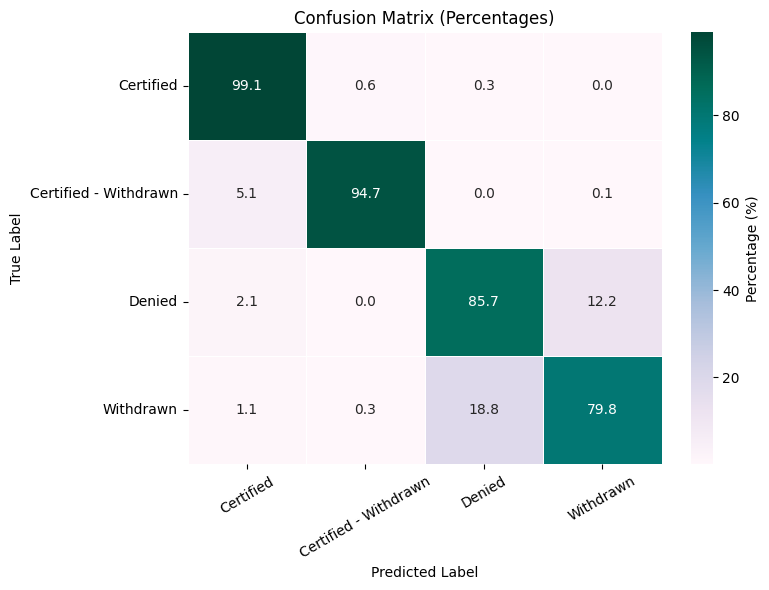

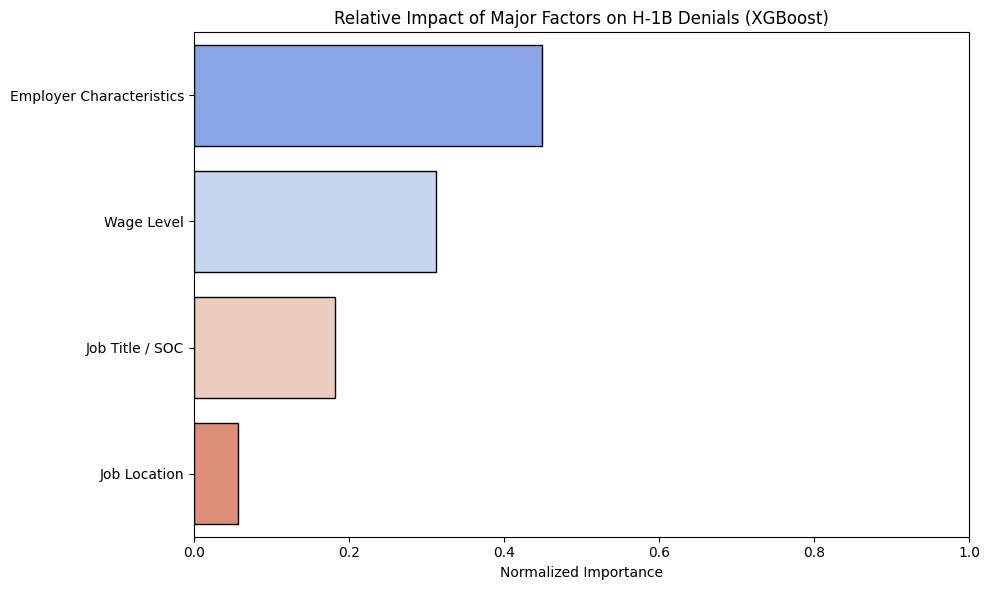

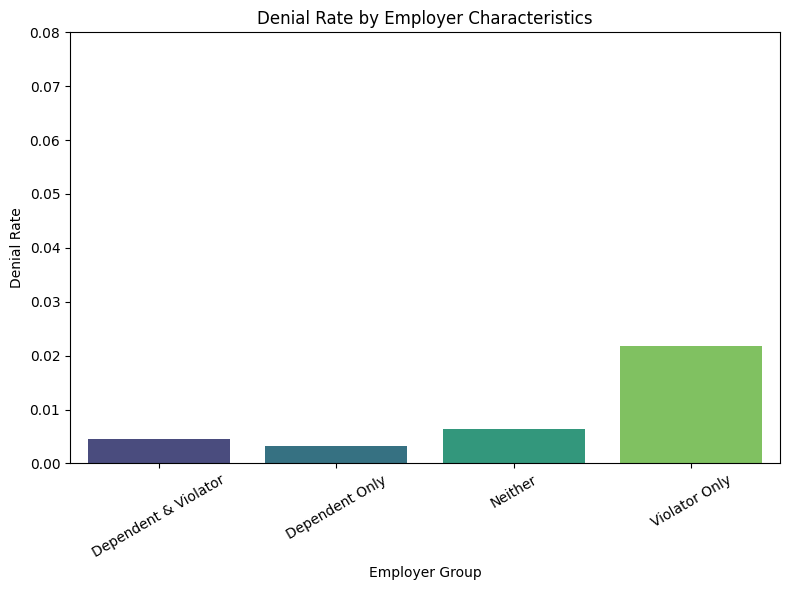

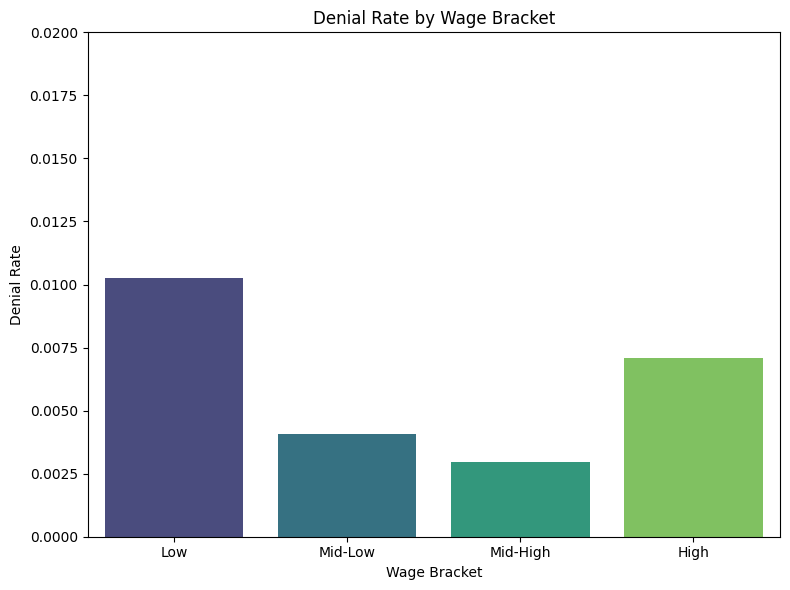

<ipython-input-9-4d70a0aefd0f>:202: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  denial_trend = pd.read_csv('/content/drive/MyDrive/Feature_Engineered_H1B_Data.csv')


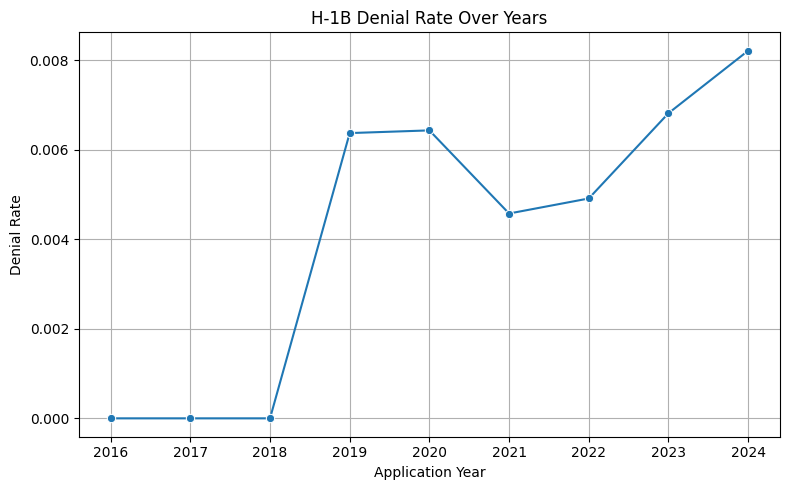

Total execution time: 102.04 seconds


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

# Start timer
start_time = time.time()

# Load dataset
input_path = '/content/drive/MyDrive/Feature_Engineered_H1B_Data_Selected_Features.csv'
data = pd.read_csv(input_path, low_memory=False)

# Drop rows with missing target
data = data.dropna(subset=['case_status'])

# Encode categorical features
cat_cols = data.select_dtypes(include='object').columns.drop('case_status')
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Encode target variable
target_le = LabelEncoder()
data['case_status'] = target_le.fit_transform(data['case_status'])

# Separate features and target
X = data.drop('case_status', axis=1)
y = data['case_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=50,           # Reduced number of trees
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=1
)
xgb_model.fit(X_train_resampled, y_train_resampled)
print(f"Model training complete. Time: {time.time() - start_time:.2f} seconds")

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

# Plot1: Confusion Matrix (Percent Format)
labels = sorted(np.unique(y_test))
label_names = target_le.inverse_transform(labels)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix (Percentages)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='PuBuGn', linewidths=0.5,
            xticklabels=label_names, yticklabels=label_names, cbar_kws={'label': 'Percentage (%)'})
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot2: Feature Importance - Combined

# Map features into 4 research categories
importances = xgb_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

def map_to_category(feature):
    if feature in ['wage_rate_hourly', 'prevailing_wage_hourly']:
        return 'Wage Level'
    elif feature in ['h_1b_dependent', 'willful_violator']:
        return 'Employer Characteristics'
    elif feature in ['job_title', 'soc_code', 'soc_title']:
        return 'Job Title / SOC'
    elif feature in ['worksite_city', 'worksite_state']:
        return 'Job Location'
    else:
        return 'Other'

importance_df['Category'] = importance_df['Feature'].apply(map_to_category)

# Group by category and normalize
category_importance = importance_df.groupby('Category')['Importance'].sum().reset_index()
category_importance = category_importance[category_importance['Category'] != 'Other']
category_importance['Normalized Impact'] = category_importance['Importance'] / category_importance['Importance'].sum()

# Plot Combined 4 Categories
plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_importance.sort_values('Normalized Impact', ascending=False),
    x='Normalized Impact',
    y='Category',
    hue='Category',        # Fix warning by assigning hue
    legend=False,
    palette='coolwarm',
    edgecolor='black'
)
plt.title('Relative Impact of Major Factors on H-1B Denials (XGBoost)')
plt.xlabel('Normalized Importance')
plt.ylabel('')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Copy data
df_viz = data.copy()
df_viz['case_status_decoded'] = target_le.inverse_transform(df_viz['case_status'])

# Plot3: Employer Characteristics vs Denial Rate
employer_plot_df = df_viz.copy()

# Create groups
employer_plot_df['Employer Group'] = employer_plot_df.apply(
    lambda row: 'Dependent & Violator' if row['h_1b_dependent'] == 1 and row['willful_violator'] == 1 else
                'Dependent Only' if row['h_1b_dependent'] == 1 else
                'Violator Only' if row['willful_violator'] == 1 else
                'Neither', axis=1
)

# Calculate denial rates
employer_denial_rate = (
    employer_plot_df.groupby('Employer Group')['case_status_decoded']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
employer_denial_rate['Denial Rate'] = employer_denial_rate.get('Denied', 0)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    data=employer_denial_rate.reset_index(),
    x='Employer Group',
    y='Denial Rate',
    hue='Employer Group',
    palette='viridis',
    legend=False
)
plt.title('Denial Rate by Employer Characteristics')
plt.ylabel('Denial Rate')
plt.xlabel('Employer Group')
plt.ylim(0, 0.08)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Plot4: Wage Bracket vs Denial Rate
df_viz['wage_bracket'] = pd.qcut(df_viz['wage_rate_hourly'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

wage_denial_rate = (
    df_viz.groupby('wage_bracket', observed=True)['case_status_decoded']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
wage_denial_rate['Denial Rate'] = wage_denial_rate.get('Denied', 0)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    data=wage_denial_rate.reset_index(),
    x='wage_bracket',
    y='Denial Rate',
    hue='wage_bracket',
    palette='viridis',
    legend=False
)
plt.title('Denial Rate by Wage Bracket')
plt.ylabel('Denial Rate')
plt.xlabel('Wage Bracket')
plt.ylim(0, 0.02)
plt.tight_layout()
plt.show()

# Load feature engineered but not feature selected data
denial_trend = pd.read_csv('/content/drive/MyDrive/Feature_Engineered_H1B_Data.csv')

# Create Denied flag
denial_trend['Denied'] = (denial_trend['case_status'] == 'Denied').astype(int)

# Plot5: Plot Denial Rate Over Years
yearly_denials = denial_trend.groupby('received_year')['Denied'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=yearly_denials, x='received_year', y='Denied', marker='o')
plt.title('H-1B Denial Rate Over Years')
plt.xlabel('Application Year')
plt.ylabel('Denial Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


# End timer
print(f"Total execution time: {time.time() - start_time:.2f} seconds")


**Comparison of Models and Feature Importance Analysis**

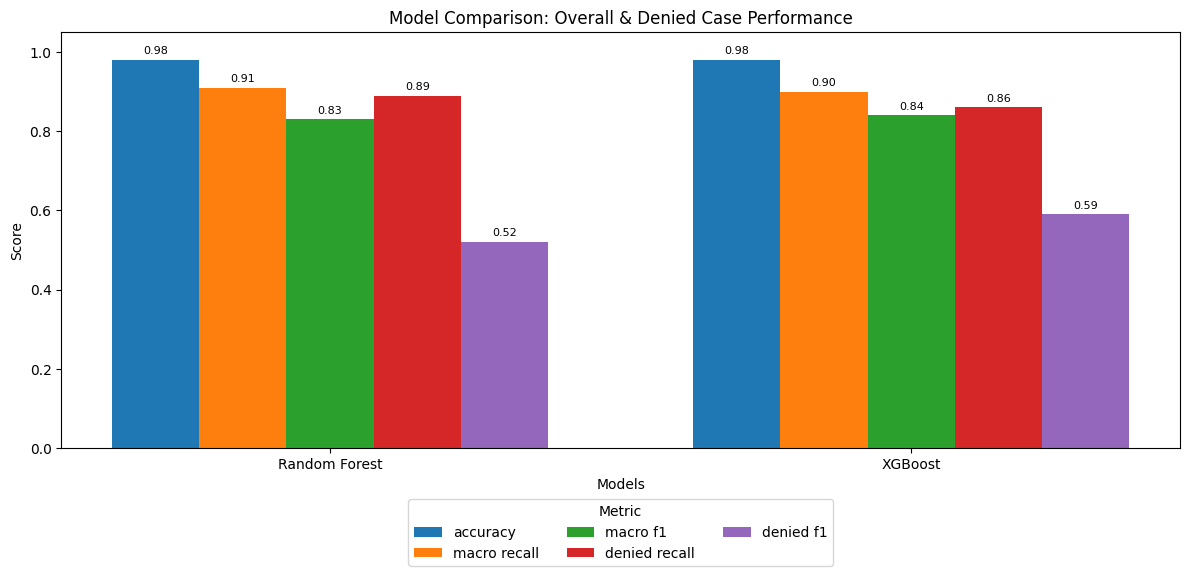

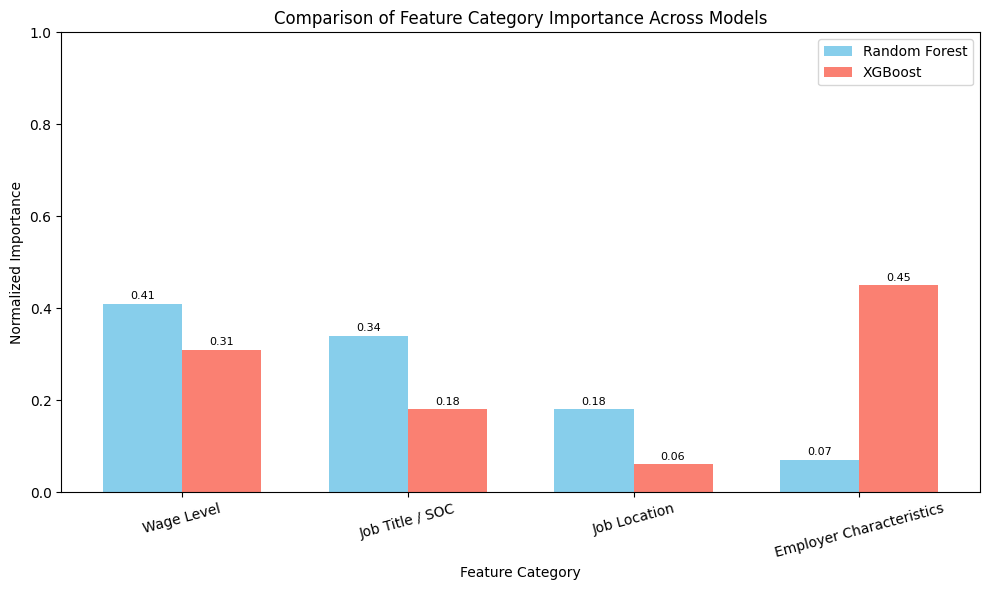

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Metrics Comparison

metrics = {
    'Random Forest': {
        'accuracy': 0.98,
        'macro recall': 0.91,
        'macro f1': 0.83,
        'denied recall': 0.89,
        'denied f1': 0.52
    },
    'XGBoost': {
        'accuracy': 0.98,
        'macro recall': 0.90,
        'macro f1': 0.84,
        'denied recall': 0.86,
        'denied f1': 0.59
    }
}

labels = ['accuracy', 'macro recall', 'macro f1', 'denied recall', 'denied f1']
model_names = list(metrics.keys())
values = np.array([[metrics[model][label] for label in labels] for model in model_names])

x = np.arange(len(model_names))
width = 0.15
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(12, 6))
for i, label in enumerate(labels):
    ax.bar(x + (i - 2) * width, values[:, i], width, label=label, color=colors[i])

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Overall & Denied Case Performance')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1.05)
ax.legend(title="Metric", loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

for i in range(len(model_names)):
    for j in range(len(labels)):
        score = values[i, j]
        ax.text(x[i] + (j - 2) * width, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Feature Category Importance Comparison

rf_importance = {
    'Wage Level': 0.41,
    'Job Title / SOC': 0.34,
    'Job Location': 0.18,
    'Employer Characteristics': 0.07
}
xgb_importance = {
    'Employer Characteristics': 0.45,
    'Wage Level': 0.31,
    'Job Title / SOC': 0.18,
    'Job Location': 0.06
}

categories = list(rf_importance.keys())
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, [rf_importance[cat] for cat in categories], width, label='Random Forest', color='skyblue')
ax.bar(x + width/2, [xgb_importance[cat] for cat in categories], width, label='XGBoost', color='salmon')

ax.set_ylabel('Normalized Importance')
ax.set_xlabel('Feature Category')
ax.set_title('Comparison of Feature Category Importance Across Models')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=15)
ax.set_ylim(0, 1)
ax.legend()

for i in range(len(categories)):
    ax.text(x[i] - width/2, rf_importance[categories[i]] + 0.01, f"{rf_importance[categories[i]]:.2f}", ha='center', fontsize=8)
    ax.text(x[i] + width/2, xgb_importance[categories[i]] + 0.01, f"{xgb_importance[categories[i]]:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()
